### Introduction to Lab 4

It’s time for Lab 4—and this time, you will work directly with AWS Lambda.

First, you will deploy the ListDragon, AddDragon, and ValidateDragon AWS Lambda functions. After you implement the functions, you will then update the GET method so that the REST application programming interface (API) can use the Lambda functions.

We strongly recommend that you explore the source code to view how the code and the Lambda handlers work. It’s important to get a better understanding of the AWS software development kit (SDK), and looking at the code that powers this application provides an opportunity to do so.

If you have questions about the lab, it’s likely that you’re not alone. Use the discussion forum to post questions to your peers in the course, and we also encourage you to answer other learners’ questions. Have fun! 

<pre>


    
</pre>
### Exercise 4

### Exercise 4: AWS Lambda Functions

https://aws-tc-largeobjects.s3.amazonaws.com/DEV-AWS-MO-BuildingRedux/exercise-4-lambda.html

<b>Note</b>  
The exercises in this course will have an associated charge in your AWS account. In this exercise, you will create the following resources:

* AWS Identity and Access Management (IAM) policy
* IAM role
* AWS Lambda functions
  
<b>The final exercise includes instructions to delete all the resources that you create in the exercises.</b>

Familiarize yourself with AWS Lambda pricing and the AWS Free Tier.

## Exercise 4: AWS Lambda Functions

In this exercise, you deploy the ListDragon, AddDragon, and ValidateDragon Lambda functions. After you implement the functions, you then update the GET method in the application programming interface (API) to use the Lambda function.

### Task 1: Creating IAM policies and roles

In this task, you will create policies and roles that the Lambda functions use. Each Lambda function needs permissions to access Amazon Simple Storage Service (Amazon S3) and the AWS Systems Manager Parameter Store. Only the AddDragon function needs permissions to write to Amazon S3.

You will start by creating a policy (dragons-read-policy) that grants permissions to read from Amazon S3. You will also create a Lambda role (dragons-read-lambda-role), and attach the policy to it.

1. In the console, open the IAM dashboard by searching for and choosing IAM.

2. In the navigation pane, under Access Management, choose Policies.

3. Choose Create Policy.

4. Choose the JSON tab and in the editor box, replace the sample policy with the following code:
```bash
    {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Action": "s3:GetObject",
                "Resource": "*"
            },
            {
                "Effect": "Allow",
                "Action": [
                    "ssm:GetParameters",
                    "ssm:GetParameter"
                ],
                "Resource": "*"
            }
        ]
    }
```

5. Choose Next: Tags, and then choose Next: Review.

6. In the Name box, enter dragons-read-policy.

7. Choose Create policy.

8. In the navigation pane, choose Roles.

9. Choose Create role.

10. In the Select trusted entity page, scroll to the Use case section and select Lambda.

11. Choose Next.

12. In the Search box, enter dragons and press Enter.

13. Select dragons-read-policy.

14. Choose Next.

15. In the Role name box, enter dragons-read-lambda-role.

16. Choose Create role.

Next, you will create a policy called dragons-readwrite-policy, which you will attach to a Lambda role called dragons-readwrite-lambda-role.

The dragons-readwrite-policy uses the following policy, which is in JavaScript Object Notation (JSON) code:
```bash
    {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow",
                "Action": ["s3:GetObject","s3:PutObject"],
                "Resource": "*"
            },
            {
                "Effect": "Allow",
                "Action": [
                    "ssm:GetParameters",
                    "ssm:GetParameter"
                ],
                "Resource": "*"
            }
        ]
    }
```

If you are familiar with IAM policies and roles, you might want to attempt to complete this section before you use the step-by-step instructions.

> Expand for step-by-step instructions.

### Restricting IAM policies

As a security best practice, the policies can be further restricted to allow only the necessary resources. The two policies that you created use a wildcard (*) to allow operations on all resources. These permissions can be restricted to Amazon Resource Names (ARNs) that allow only the resources that the Lambda functions need.

1. To update the wildcard * resources, return to the JSON policy editor for the dragons-readwrite-policy and dragons-read-policy.

2. Use the following policy fragment to update the Amazon S3 actions in both of your dragons policies. Replace <YOUR-BUCKET> with your unique bucket name.

    `"Resource": "arn:aws:s3:::<YOUR-BUCKET>/*"`

    Note: The ARN format for Amazon S3 is: `arn:aws:s3:::bucket_name/key_name`. For more information about Amazon S3 ARNs, see Amazon S3 resources (https://docs.aws.amazon.com/AmazonS3/latest/userguide/s3-arn-format.html) in the Amazon S3 User Guide.

    The policy will now be restricted to keys in your Dragons application bucket.

3. Use the following policy fragment to update the AWS Systems Manager actions in your policies. Replace <ACCOUNT-ID> with your AWS account ID.

    <b>Tip:</b> If you need your AWS account ID, follow the instructions in Finding your AWS account ID (https://docs.aws.amazon.com/IAM/latest/UserGuide/console_account-alias.html#FindingYourAWSId) in the IAM User Guide.

   `"Resource": "arn:aws:ssm:us-east-1:<ACCOUNT-ID>:parameter/dragon*"`

    <b>Note:</b> The ARN format for an AWS Systems Manager parameter is: arn:aws:ssm:region:account:parameter/parameter_name. For more information about AWS Systems Manager ARNs, see Resource types defined by AWS Systems Manager in the IAM Service Authorization Reference.

The following is an example of the dragons-readwrite-policy.

```bash
    {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:PutObject"
            ],
            "Resource": "arn:aws:s3:::<YOUR-BUCKET>/*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ssm:GetParameters",
                "ssm:GetParameter"
            ],
            "Resource": "arn:aws:ssm:us-east-1:<ACCOUNT-ID>:parameter/dragon*"
        }
    ]
    }
```


The policy will now be restricted to parameters that begin with `dragon`.

### Task 2: Downloading the source code

In this task, you will download and extract the Lambda function code.

1. In the AWS Cloud9 or local IDE terminal, download and extract the Lambda code.

    `wget https://aws-tc-largeobjects.s3.amazonaws.com/DEV-AWS-MO-BuildingRedux/downloads/python-dragons-lambda.zip`
    `unzip python-dragons-lambda.zip -d ~/python-dragons-lambda`

The archive contains the code for the three functions, and sample payload files.

    .
    ├── AddDragon
    │·· ├── addDragon.py
    │·· └── newDragonPayload.json
    ├── ListDragons
    │·· └── listDragonsLambda.py
    └── ValidateDragon
        ├── duplicateDragonPayload.json
        ├── newDragonPayload.json
        └── validateDragon.py
    
### Task 3: Deploying and invoking Lambda functions

In this task, you will deploy and invoke the `ListDragon`, `AddDragon`, and `ValidateDragon` Lambda functions by using the AWS Command Line Interface (AWS CLI).

1. In the AWS Cloud9 or local IDE terminal, save the ARNs for the Lambda roles in environment variables.

```
   export ROLE_ARN_READWRITE=`aws iam get-role --role-name dragons-readwrite-lambda-role  --query 'Role.Arn' --output text`
```

```     
   export ROLE_ARN_READ=`aws iam get-role --role-name dragons-read-lambda-role  --query 'Role.Arn' --output text`
```

3. Inspect the environment variables.
```
echo $ROLE_ARN_READ $ROLE_ARN_READWRITE
```

The ARNs will be in the format: `arn:aws:iam::<account number>:role/<role name>`. You will use the role ARNs in the following steps when you create the Lambda functions.

3. Change to the directory that contains the `ListDragons` code.

`cd ~/python-dragons-lambda/ListDragons`

4. Install the boto3 Python library. The SDK for Python (Boto3) is present in the Lambda runtime environment, but we have decided to control the version that’s used by including it in the package.

`pip3 install -t package boto3`

For more information about the Lambda runtime environments for Python, see Building Lambda functions with Python (https://docs.aws.amazon.com/lambda/latest/dg/lambda-python.html) in the AWS Lambda Developer Guide.

5. Create a .zip file that contains the contents of your ListDragons folder, including subfolders.

`cd package`
`zip -r ../pythonlistDragonsFunction.zip .`

6. Add the listDragons.py file to the .zip file.

`cd ..`
`zip -g pythonlistDragonsFunction.zip listDragons.py`

7. Create the function, and upload the code package by using the create-function command.
```bash
aws lambda create-function --function-name ListDragons \
--runtime python3.9  \
--role $ROLE_ARN_READ \
--handler listDragons.listDragons \
--publish \
--zip-file fileb://pythonlistDragonsFunction.zip
```

8. Invoke the function with an empty payload.

`aws lambda invoke --function-name ListDragons output.txt`

9. View the response by entering the following command.

`cat output.txt`

Next, you perform the same steps to add AddDragon and ValidateDragon functions.

10. Install the boto3 library, and package AddDragon.
```bash
cd ~/python-dragons-lambda/AddDragon
pip3 install -t package boto3
cd package
zip -r ../pythonaddDragonFunction.zip . 
cd ..
zip -g pythonaddDragonFunction.zip addDragon.py
```

11. Create and invoke the AddDragon function with the sample payload.
```bash
aws lambda create-function --function-name AddDragon \
--runtime python3.9  \
--role $ROLE_ARN_READWRITE \
--handler addDragon.addDragonToFile \
--publish \
--zip-file fileb://pythonaddDragonFunction.zip
```
  
`aws lambda invoke --function-name AddDragon --payload fileb://newDragonPayload.json output.txt ; cat output.txt`

12. Install the boto3 library, and package ValidateDragon:
```bash
cd ~/python-dragons-lambda/ValidateDragon
pip3 install -t package boto3
cd package
zip -r ../pythonvalidateDragonFunction.zip . 
cd ..
zip -g pythonvalidateDragonFunction.zip validateDragon.py
```
  
13. Create and invoke the ValidateDragon function with the sample payloads:
```bash
aws lambda create-function --function-name ValidateDragon \
--runtime python3.9  \
--role $ROLE_ARN_READ \
--handler validateDragon.validate \
--publish \
--zip-file fileb://pythonvalidateDragonFunction.zip
```
  
14. Observe that the duplicateDragonPayload.json payload raises a DragonValidationException.

``` bash
aws lambda invoke --function-name ValidateDragon --payload fileb://newDragonPayload.json output.txt ; cat output.txt
aws lambda invoke --function-name ValidateDragon --payload fileb://duplicateDragonPayload.json output.txt ; cat output.txt
```


### Task 4: Updating the GET method for the REST API

In this task, you will update the GET method for the REST API to invoke your Lambda function. You will remove the mock integration that is currently used in the GET method. You will then connect the method to the Lambda function.

    1. In the console, open the Amazon API Gateway dashboard by searching for and choosing API Gateway.

    2. Make sure that you are in the N. Virginia Region (us-east-1).

    3. Choose the DragonsApp REST API.

    4. In the Resources navigation pane, choose the GET method for the /dragons resource.

    5. Choose Integration Request, and configure the following settings.
        * Integration type: Lambda Function
        * Use Lambda Proxy integration: Select this option
        * Lambda Region: us-east-1
        * Lambda Function: ListDragons  
        
    6. Choose Save.

    7. When you are prompted with Are you sure you want to switch to a Lambda Proxy integration?, choose OK.

    8. When you are prompted to Add Permission to Lambda Function, choose OK.

    9. Select Actions > Deploy API.

    10. For Deployment stage, select prod.

    11. Choose Deploy.

### Task 5: Testing in the web application

In this task, you will test the updated GET method from the web application. The GET method will invoke the ListDragons Lambda function.

    1. Visit the URL for your Dragons application. If you don’t have it bookmarked, the URL will be `https://<MY-BUCKET>.s3.amazonaws.com/dragonsapp/index.html`. Replace <MY-BUCKET> with the unique bucket name that you created previously.  
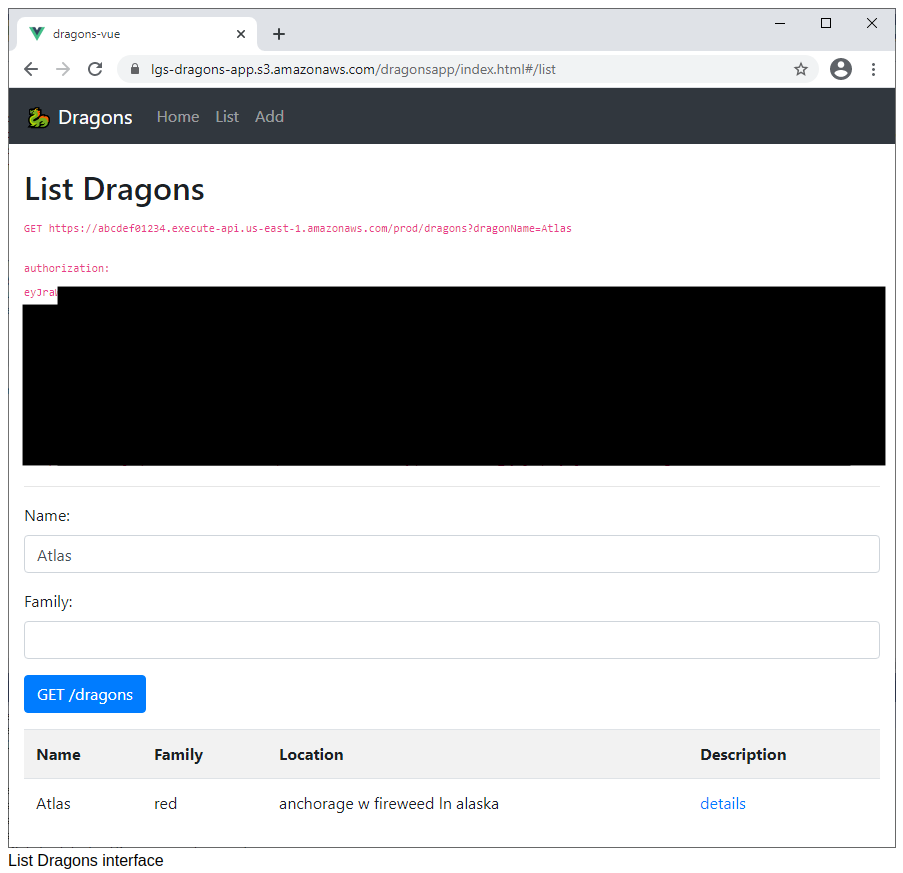
  
    <b>Note</b>: The application remembers your Dragons endpoint, Amazon Cognito domain, and Amazon Cognito client ID. If these resources aren’t available, you can retrieve them from the previous exercises.

    2. In the web application, choose Login. The login flow will update the Amazon Cognito ID token in your application.

    3. After you complete the login, choose List.

    4. Choose GET /dragons. You should see the API response from the ListDragons Lambda function.

    5. Confirm that the function works correctly by experimenting with different values for Name and Family.
